In [16]:
!pip install torch torchvision
!pip install pillow
!pip install scikit-learn
!pip install matplotlib
!pip install tqdm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import time
import torch.cuda
from tqdm import tqdm #Barra de progreso

In [14]:
class PlantDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    # Acceder a un elemento especifico del dataset
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [15]:
# Definición de transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Definición de directorios y categorías
data_dir = 'D:/processed_plantas'
categories = ['arocarbol', 'durazno', 'guayabilla', 'matico', 'tuna']
img_paths = []
labels = []

# Recolección de imágenes y etiquetas
for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    img_names = os.listdir(category_path)
    random.shuffle(img_names)
    img_names = img_names[:10000]
    img_paths += [os.path.join(category_path, img_name) for img_name in img_names]
    labels += [label] * len(img_names)

# División en conjunto de entrenamiento y prueba
train_paths, test_paths, train_labels, test_labels = train_test_split(img_paths, labels, test_size=0.2, stratify=labels)

# Creación de DataLoaders
train_dataset = PlantDataset(train_paths, train_labels, transform=transform)
test_dataset = PlantDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


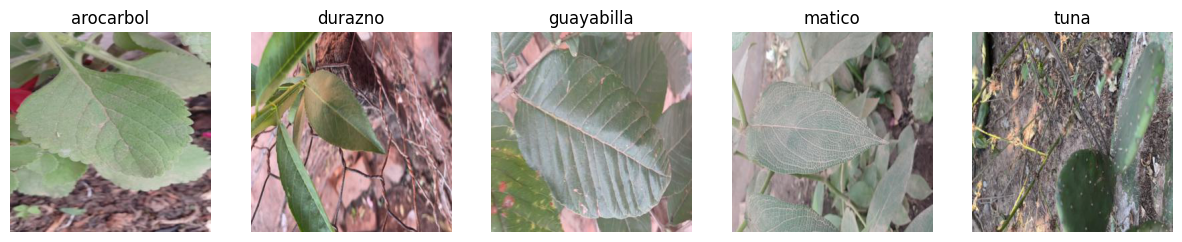

In [16]:
# Acceder a un elemento especifico del dataset
def show_sample_images(categories, data_dir):
    fig, axs = plt.subplots(1, len(categories), figsize=(15, 5))
    for i, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        img_names = os.listdir(category_path)
        img_path = os.path.join(category_path, random.choice(img_names))
        image = Image.open(img_path)
        axs[i].imshow(image)
        axs[i].set_title(f'{category.split()[0]}')
        axs[i].axis('off')
    plt.show()

show_sample_images(categories, data_dir)


In [17]:
# Acceder a un elemento especifico del dataset
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(300*300*3, 50)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, 5)

    def forward(self, x):
        x = x.view(-1, 300*300*3)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [18]:
# Preparación del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Crear instancia MLP y mueve a la GPU
model = MLP().to(device)

print(f'Model is on: {next(model.parameters()).device}')

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Función para guardar checkpoints
def save_checkpoint(epoch, model, optimizer, filename='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filename)


Model is on: cuda:0


In [19]:
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    # Usa tqdm para la barra de progreso
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    epoch_time = time.time() - start_time
    memory_allocated = torch.cuda.memory_allocated(device) / (1024 ** 3)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Time: {epoch_time:.2f}s, Memory: {memory_allocated:.2f} GB')

    if (epoch+1) % 20 == 0:
        save_checkpoint(epoch+1, model, optimizer)


Epoch 1/300: 100%|██████████| 1250/1250 [03:15<00:00,  6.39batch/s]


Epoch [1/300]
Loss: 2.1122, Accuracy: 33.18%, Time: 195.57s, Memory: 0.25 GB


Epoch 2/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.96batch/s]


Epoch [2/300]
Loss: 1.4729, Accuracy: 39.99%, Time: 179.58s, Memory: 0.25 GB


Epoch 3/300: 100%|██████████| 1250/1250 [02:45<00:00,  7.57batch/s]


Epoch [3/300]
Loss: 1.4593, Accuracy: 41.48%, Time: 165.21s, Memory: 0.25 GB


Epoch 4/300: 100%|██████████| 1250/1250 [02:44<00:00,  7.61batch/s]


Epoch [4/300]
Loss: 1.4824, Accuracy: 41.23%, Time: 164.27s, Memory: 0.25 GB


Epoch 5/300: 100%|██████████| 1250/1250 [02:43<00:00,  7.66batch/s]


Epoch [5/300]
Loss: 1.5800, Accuracy: 40.80%, Time: 163.16s, Memory: 0.25 GB


Epoch 6/300: 100%|██████████| 1250/1250 [02:46<00:00,  7.50batch/s]


Epoch [6/300]
Loss: 1.5740, Accuracy: 41.02%, Time: 166.56s, Memory: 0.25 GB


Epoch 7/300: 100%|██████████| 1250/1250 [02:46<00:00,  7.51batch/s]


Epoch [7/300]
Loss: 1.5628, Accuracy: 41.44%, Time: 166.44s, Memory: 0.25 GB


Epoch 8/300: 100%|██████████| 1250/1250 [02:43<00:00,  7.62batch/s]


Epoch [8/300]
Loss: 1.6328, Accuracy: 41.21%, Time: 164.01s, Memory: 0.25 GB


Epoch 9/300: 100%|██████████| 1250/1250 [02:41<00:00,  7.76batch/s]


Epoch [9/300]
Loss: 1.5957, Accuracy: 40.98%, Time: 161.15s, Memory: 0.25 GB


Epoch 10/300: 100%|██████████| 1250/1250 [02:39<00:00,  7.83batch/s]


Epoch [10/300]
Loss: 1.5629, Accuracy: 41.51%, Time: 159.66s, Memory: 0.25 GB


Epoch 11/300: 100%|██████████| 1250/1250 [02:42<00:00,  7.70batch/s]


Epoch [11/300]
Loss: 1.6301, Accuracy: 41.21%, Time: 162.31s, Memory: 0.25 GB


Epoch 12/300: 100%|██████████| 1250/1250 [02:41<00:00,  7.76batch/s]


Epoch [12/300]
Loss: 1.6326, Accuracy: 41.61%, Time: 161.11s, Memory: 0.25 GB


Epoch 13/300: 100%|██████████| 1250/1250 [02:43<00:00,  7.63batch/s]


Epoch [13/300]
Loss: 1.5386, Accuracy: 42.02%, Time: 163.85s, Memory: 0.25 GB


Epoch 14/300: 100%|██████████| 1250/1250 [02:42<00:00,  7.70batch/s]


Epoch [14/300]
Loss: 1.5767, Accuracy: 42.04%, Time: 162.33s, Memory: 0.25 GB


Epoch 15/300: 100%|██████████| 1250/1250 [02:43<00:00,  7.65batch/s]


Epoch [15/300]
Loss: 1.5891, Accuracy: 42.52%, Time: 163.33s, Memory: 0.25 GB


Epoch 16/300: 100%|██████████| 1250/1250 [02:39<00:00,  7.84batch/s]


Epoch [16/300]
Loss: 1.5699, Accuracy: 42.48%, Time: 159.53s, Memory: 0.25 GB


Epoch 17/300: 100%|██████████| 1250/1250 [02:44<00:00,  7.60batch/s]


Epoch [17/300]
Loss: 1.5491, Accuracy: 42.44%, Time: 164.39s, Memory: 0.25 GB


Epoch 18/300: 100%|██████████| 1250/1250 [02:40<00:00,  7.78batch/s]


Epoch [18/300]
Loss: 1.5982, Accuracy: 42.53%, Time: 160.75s, Memory: 0.25 GB


Epoch 19/300: 100%|██████████| 1250/1250 [02:42<00:00,  7.70batch/s]


Epoch [19/300]
Loss: 1.5351, Accuracy: 42.64%, Time: 162.30s, Memory: 0.25 GB


Epoch 20/300: 100%|██████████| 1250/1250 [02:39<00:00,  7.83batch/s]


Epoch [20/300]
Loss: 1.6434, Accuracy: 41.78%, Time: 159.63s, Memory: 0.25 GB


Epoch 21/300: 100%|██████████| 1250/1250 [02:39<00:00,  7.85batch/s]


Epoch [21/300]
Loss: 1.5601, Accuracy: 42.62%, Time: 159.14s, Memory: 0.25 GB


Epoch 22/300: 100%|██████████| 1250/1250 [02:40<00:00,  7.77batch/s]


Epoch [22/300]
Loss: 1.4798, Accuracy: 43.01%, Time: 160.79s, Memory: 0.25 GB


Epoch 23/300: 100%|██████████| 1250/1250 [02:43<00:00,  7.63batch/s]


Epoch [23/300]
Loss: 1.6059, Accuracy: 42.91%, Time: 163.78s, Memory: 0.25 GB


Epoch 24/300: 100%|██████████| 1250/1250 [02:44<00:00,  7.59batch/s]


Epoch [24/300]
Loss: 1.5028, Accuracy: 43.31%, Time: 164.59s, Memory: 0.25 GB


Epoch 25/300: 100%|██████████| 1250/1250 [02:43<00:00,  7.63batch/s]


Epoch [25/300]
Loss: 1.5533, Accuracy: 43.36%, Time: 163.91s, Memory: 0.25 GB


Epoch 26/300: 100%|██████████| 1250/1250 [02:36<00:00,  7.98batch/s]


Epoch [26/300]
Loss: 1.4373, Accuracy: 43.64%, Time: 156.61s, Memory: 0.25 GB


Epoch 27/300: 100%|██████████| 1250/1250 [02:36<00:00,  7.97batch/s]


Epoch [27/300]
Loss: 1.5138, Accuracy: 43.52%, Time: 156.75s, Memory: 0.25 GB


Epoch 28/300: 100%|██████████| 1250/1250 [03:07<00:00,  6.65batch/s]


Epoch [28/300]
Loss: 1.5350, Accuracy: 43.78%, Time: 187.93s, Memory: 0.25 GB


Epoch 29/300: 100%|██████████| 1250/1250 [03:41<00:00,  5.64batch/s]


Epoch [29/300]
Loss: 1.6130, Accuracy: 43.22%, Time: 221.65s, Memory: 0.25 GB


Epoch 30/300: 100%|██████████| 1250/1250 [03:17<00:00,  6.33batch/s]


Epoch [30/300]
Loss: 1.4990, Accuracy: 43.23%, Time: 197.58s, Memory: 0.25 GB


Epoch 31/300: 100%|██████████| 1250/1250 [03:18<00:00,  6.31batch/s]


Epoch [31/300]
Loss: 1.4719, Accuracy: 44.24%, Time: 198.07s, Memory: 0.25 GB


Epoch 32/300: 100%|██████████| 1250/1250 [03:14<00:00,  6.44batch/s]


Epoch [32/300]
Loss: 1.4839, Accuracy: 44.41%, Time: 194.07s, Memory: 0.25 GB


Epoch 33/300: 100%|██████████| 1250/1250 [03:14<00:00,  6.42batch/s]


Epoch [33/300]
Loss: 1.4624, Accuracy: 43.89%, Time: 194.62s, Memory: 0.25 GB


Epoch 34/300: 100%|██████████| 1250/1250 [03:12<00:00,  6.49batch/s]


Epoch [34/300]
Loss: 1.5497, Accuracy: 43.55%, Time: 192.60s, Memory: 0.25 GB


Epoch 35/300: 100%|██████████| 1250/1250 [03:11<00:00,  6.52batch/s]


Epoch [35/300]
Loss: 1.4492, Accuracy: 43.73%, Time: 191.86s, Memory: 0.25 GB


Epoch 36/300: 100%|██████████| 1250/1250 [03:15<00:00,  6.41batch/s]


Epoch [36/300]
Loss: 1.5855, Accuracy: 44.13%, Time: 195.10s, Memory: 0.25 GB


Epoch 37/300: 100%|██████████| 1250/1250 [03:15<00:00,  6.38batch/s]


Epoch [37/300]
Loss: 1.4200, Accuracy: 43.84%, Time: 195.88s, Memory: 0.25 GB


Epoch 38/300: 100%|██████████| 1250/1250 [03:18<00:00,  6.29batch/s]


Epoch [38/300]
Loss: 1.4874, Accuracy: 44.03%, Time: 198.71s, Memory: 0.25 GB


Epoch 39/300: 100%|██████████| 1250/1250 [03:27<00:00,  6.04batch/s]


Epoch [39/300]
Loss: 1.4470, Accuracy: 44.92%, Time: 207.12s, Memory: 0.25 GB


Epoch 40/300: 100%|██████████| 1250/1250 [03:15<00:00,  6.39batch/s]


Epoch [40/300]
Loss: 1.5186, Accuracy: 44.01%, Time: 195.53s, Memory: 0.25 GB


Epoch 41/300: 100%|██████████| 1250/1250 [03:24<00:00,  6.11batch/s]


Epoch [41/300]
Loss: 1.4269, Accuracy: 44.94%, Time: 204.62s, Memory: 0.25 GB


Epoch 42/300: 100%|██████████| 1250/1250 [03:37<00:00,  5.74batch/s]


Epoch [42/300]
Loss: 1.4603, Accuracy: 43.86%, Time: 217.63s, Memory: 0.25 GB


Epoch 43/300: 100%|██████████| 1250/1250 [03:14<00:00,  6.43batch/s]


Epoch [43/300]
Loss: 1.4149, Accuracy: 44.26%, Time: 194.30s, Memory: 0.25 GB


Epoch 44/300: 100%|██████████| 1250/1250 [03:24<00:00,  6.10batch/s]


Epoch [44/300]
Loss: 1.4712, Accuracy: 45.17%, Time: 204.89s, Memory: 0.25 GB


Epoch 45/300: 100%|██████████| 1250/1250 [03:04<00:00,  6.79batch/s]


Epoch [45/300]
Loss: 1.4701, Accuracy: 44.26%, Time: 184.16s, Memory: 0.25 GB


Epoch 46/300: 100%|██████████| 1250/1250 [03:04<00:00,  6.78batch/s]


Epoch [46/300]
Loss: 1.4719, Accuracy: 44.44%, Time: 184.30s, Memory: 0.25 GB


Epoch 47/300: 100%|██████████| 1250/1250 [03:00<00:00,  6.94batch/s]


Epoch [47/300]
Loss: 1.5454, Accuracy: 44.48%, Time: 180.22s, Memory: 0.25 GB


Epoch 48/300: 100%|██████████| 1250/1250 [02:56<00:00,  7.07batch/s]


Epoch [48/300]
Loss: 1.3829, Accuracy: 45.06%, Time: 176.73s, Memory: 0.25 GB


Epoch 49/300: 100%|██████████| 1250/1250 [02:54<00:00,  7.16batch/s]


Epoch [49/300]
Loss: 1.4198, Accuracy: 45.24%, Time: 174.61s, Memory: 0.25 GB


Epoch 50/300: 100%|██████████| 1250/1250 [02:49<00:00,  7.36batch/s]


Epoch [50/300]
Loss: 1.4197, Accuracy: 44.73%, Time: 169.94s, Memory: 0.25 GB


Epoch 51/300: 100%|██████████| 1250/1250 [03:00<00:00,  6.92batch/s]


Epoch [51/300]
Loss: 1.3579, Accuracy: 45.34%, Time: 180.64s, Memory: 0.25 GB


Epoch 52/300: 100%|██████████| 1250/1250 [03:26<00:00,  6.06batch/s]


Epoch [52/300]
Loss: 1.4052, Accuracy: 45.31%, Time: 206.18s, Memory: 0.25 GB


Epoch 53/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.97batch/s]


Epoch [53/300]
Loss: 1.3601, Accuracy: 45.28%, Time: 179.45s, Memory: 0.25 GB


Epoch 54/300: 100%|██████████| 1250/1250 [02:48<00:00,  7.41batch/s]


Epoch [54/300]
Loss: 1.5157, Accuracy: 44.12%, Time: 168.78s, Memory: 0.25 GB


Epoch 55/300: 100%|██████████| 1250/1250 [02:56<00:00,  7.10batch/s]


Epoch [55/300]
Loss: 1.5057, Accuracy: 45.08%, Time: 176.10s, Memory: 0.25 GB


Epoch 56/300: 100%|██████████| 1250/1250 [02:47<00:00,  7.46batch/s]


Epoch [56/300]
Loss: 1.4186, Accuracy: 44.29%, Time: 167.49s, Memory: 0.25 GB


Epoch 57/300: 100%|██████████| 1250/1250 [02:50<00:00,  7.33batch/s]


Epoch [57/300]
Loss: 1.3778, Accuracy: 45.26%, Time: 170.44s, Memory: 0.25 GB


Epoch 58/300: 100%|██████████| 1250/1250 [03:11<00:00,  6.53batch/s]


Epoch [58/300]
Loss: 1.5519, Accuracy: 44.64%, Time: 191.45s, Memory: 0.25 GB


Epoch 59/300: 100%|██████████| 1250/1250 [02:49<00:00,  7.38batch/s]


Epoch [59/300]
Loss: 1.5208, Accuracy: 45.30%, Time: 169.35s, Memory: 0.25 GB


Epoch 60/300: 100%|██████████| 1250/1250 [02:49<00:00,  7.38batch/s]


Epoch [60/300]
Loss: 1.3862, Accuracy: 44.93%, Time: 169.29s, Memory: 0.25 GB


Epoch 61/300: 100%|██████████| 1250/1250 [02:55<00:00,  7.14batch/s]


Epoch [61/300]
Loss: 1.3196, Accuracy: 45.59%, Time: 175.09s, Memory: 0.25 GB


Epoch 62/300: 100%|██████████| 1250/1250 [02:52<00:00,  7.23batch/s]


Epoch [62/300]
Loss: 1.4469, Accuracy: 45.36%, Time: 172.87s, Memory: 0.25 GB


Epoch 63/300: 100%|██████████| 1250/1250 [03:00<00:00,  6.93batch/s]


Epoch [63/300]
Loss: 1.3154, Accuracy: 45.97%, Time: 180.34s, Memory: 0.25 GB


Epoch 64/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.97batch/s]


Epoch [64/300]
Loss: 1.3425, Accuracy: 46.39%, Time: 179.33s, Memory: 0.25 GB


Epoch 65/300: 100%|██████████| 1250/1250 [03:02<00:00,  6.83batch/s]


Epoch [65/300]
Loss: 1.3357, Accuracy: 45.84%, Time: 182.94s, Memory: 0.25 GB


Epoch 66/300: 100%|██████████| 1250/1250 [03:10<00:00,  6.55batch/s]


Epoch [66/300]
Loss: 1.4882, Accuracy: 45.84%, Time: 190.74s, Memory: 0.25 GB


Epoch 67/300: 100%|██████████| 1250/1250 [03:04<00:00,  6.76batch/s]


Epoch [67/300]
Loss: 1.5188, Accuracy: 45.45%, Time: 184.84s, Memory: 0.25 GB


Epoch 68/300: 100%|██████████| 1250/1250 [02:57<00:00,  7.02batch/s]


Epoch [68/300]
Loss: 1.3460, Accuracy: 45.83%, Time: 177.98s, Memory: 0.25 GB


Epoch 69/300: 100%|██████████| 1250/1250 [02:53<00:00,  7.22batch/s]


Epoch [69/300]
Loss: 1.3664, Accuracy: 45.63%, Time: 173.05s, Memory: 0.25 GB


Epoch 70/300: 100%|██████████| 1250/1250 [02:55<00:00,  7.11batch/s]


Epoch [70/300]
Loss: 1.4865, Accuracy: 45.40%, Time: 175.72s, Memory: 0.25 GB


Epoch 71/300: 100%|██████████| 1250/1250 [03:05<00:00,  6.73batch/s]


Epoch [71/300]
Loss: 1.3255, Accuracy: 46.03%, Time: 185.62s, Memory: 0.25 GB


Epoch 72/300: 100%|██████████| 1250/1250 [03:34<00:00,  5.83batch/s]


Epoch [72/300]
Loss: 1.4326, Accuracy: 45.80%, Time: 214.59s, Memory: 0.25 GB


Epoch 73/300: 100%|██████████| 1250/1250 [03:33<00:00,  5.86batch/s]


Epoch [73/300]
Loss: 1.4241, Accuracy: 45.95%, Time: 213.14s, Memory: 0.25 GB


Epoch 74/300: 100%|██████████| 1250/1250 [03:19<00:00,  6.26batch/s]


Epoch [74/300]
Loss: 1.3804, Accuracy: 46.23%, Time: 199.84s, Memory: 0.25 GB


Epoch 75/300: 100%|██████████| 1250/1250 [03:20<00:00,  6.24batch/s]


Epoch [75/300]
Loss: 1.2845, Accuracy: 46.33%, Time: 200.21s, Memory: 0.25 GB


Epoch 76/300: 100%|██████████| 1250/1250 [02:56<00:00,  7.09batch/s]


Epoch [76/300]
Loss: 1.3740, Accuracy: 46.03%, Time: 176.41s, Memory: 0.25 GB


Epoch 77/300: 100%|██████████| 1250/1250 [03:13<00:00,  6.45batch/s]


Epoch [77/300]
Loss: 1.4210, Accuracy: 45.54%, Time: 193.81s, Memory: 0.25 GB


Epoch 78/300: 100%|██████████| 1250/1250 [03:14<00:00,  6.43batch/s]


Epoch [78/300]
Loss: 1.3860, Accuracy: 45.95%, Time: 194.36s, Memory: 0.25 GB


Epoch 79/300: 100%|██████████| 1250/1250 [03:15<00:00,  6.38batch/s]


Epoch [79/300]
Loss: 1.4094, Accuracy: 45.69%, Time: 195.88s, Memory: 0.25 GB


Epoch 80/300: 100%|██████████| 1250/1250 [03:05<00:00,  6.73batch/s]


Epoch [80/300]
Loss: 1.3316, Accuracy: 46.76%, Time: 185.81s, Memory: 0.25 GB


Epoch 81/300: 100%|██████████| 1250/1250 [03:24<00:00,  6.12batch/s]


Epoch [81/300]
Loss: 1.2756, Accuracy: 46.63%, Time: 204.10s, Memory: 0.25 GB


Epoch 82/300: 100%|██████████| 1250/1250 [03:22<00:00,  6.16batch/s]


Epoch [82/300]
Loss: 1.3631, Accuracy: 46.39%, Time: 202.87s, Memory: 0.25 GB


Epoch 83/300: 100%|██████████| 1250/1250 [03:22<00:00,  6.19batch/s]


Epoch [83/300]
Loss: 1.3013, Accuracy: 46.62%, Time: 202.09s, Memory: 0.25 GB


Epoch 84/300: 100%|██████████| 1250/1250 [03:26<00:00,  6.05batch/s]


Epoch [84/300]
Loss: 1.4802, Accuracy: 46.42%, Time: 206.58s, Memory: 0.25 GB


Epoch 85/300: 100%|██████████| 1250/1250 [03:18<00:00,  6.29batch/s]


Epoch [85/300]
Loss: 1.3994, Accuracy: 46.30%, Time: 198.80s, Memory: 0.25 GB


Epoch 86/300: 100%|██████████| 1250/1250 [03:27<00:00,  6.03batch/s]


Epoch [86/300]
Loss: 1.2531, Accuracy: 46.53%, Time: 207.46s, Memory: 0.25 GB


Epoch 87/300: 100%|██████████| 1250/1250 [03:24<00:00,  6.12batch/s]


Epoch [87/300]
Loss: 1.3680, Accuracy: 46.09%, Time: 204.19s, Memory: 0.25 GB


Epoch 88/300: 100%|██████████| 1250/1250 [03:24<00:00,  6.12batch/s]


Epoch [88/300]
Loss: 1.2965, Accuracy: 46.90%, Time: 204.15s, Memory: 0.25 GB


Epoch 89/300: 100%|██████████| 1250/1250 [03:09<00:00,  6.58batch/s]


Epoch [89/300]
Loss: 1.3187, Accuracy: 46.56%, Time: 190.01s, Memory: 0.25 GB


Epoch 90/300: 100%|██████████| 1250/1250 [03:17<00:00,  6.34batch/s]


Epoch [90/300]
Loss: 1.3381, Accuracy: 46.87%, Time: 197.08s, Memory: 0.25 GB


Epoch 91/300: 100%|██████████| 1250/1250 [03:17<00:00,  6.33batch/s]


Epoch [91/300]
Loss: 1.3651, Accuracy: 46.92%, Time: 197.55s, Memory: 0.25 GB


Epoch 92/300: 100%|██████████| 1250/1250 [03:25<00:00,  6.09batch/s]


Epoch [92/300]
Loss: 1.3814, Accuracy: 46.68%, Time: 205.36s, Memory: 0.25 GB


Epoch 93/300: 100%|██████████| 1250/1250 [03:10<00:00,  6.57batch/s]


Epoch [93/300]
Loss: 1.4309, Accuracy: 46.44%, Time: 190.22s, Memory: 0.25 GB


Epoch 94/300: 100%|██████████| 1250/1250 [03:22<00:00,  6.16batch/s]


Epoch [94/300]
Loss: 1.2806, Accuracy: 46.67%, Time: 202.93s, Memory: 0.25 GB


Epoch 95/300: 100%|██████████| 1250/1250 [03:27<00:00,  6.03batch/s]


Epoch [95/300]
Loss: 1.3146, Accuracy: 47.03%, Time: 207.26s, Memory: 0.25 GB


Epoch 96/300: 100%|██████████| 1250/1250 [03:27<00:00,  6.03batch/s]


Epoch [96/300]
Loss: 1.4227, Accuracy: 46.33%, Time: 207.28s, Memory: 0.25 GB


Epoch 97/300: 100%|██████████| 1250/1250 [03:26<00:00,  6.07batch/s]


Epoch [97/300]
Loss: 1.4476, Accuracy: 46.38%, Time: 206.05s, Memory: 0.25 GB


Epoch 98/300: 100%|██████████| 1250/1250 [03:35<00:00,  5.81batch/s]


Epoch [98/300]
Loss: 1.2954, Accuracy: 47.06%, Time: 215.13s, Memory: 0.25 GB


Epoch 99/300: 100%|██████████| 1250/1250 [03:27<00:00,  6.02batch/s]


Epoch [99/300]
Loss: 1.2903, Accuracy: 46.77%, Time: 207.57s, Memory: 0.25 GB


Epoch 100/300: 100%|██████████| 1250/1250 [03:19<00:00,  6.25batch/s]


Epoch [100/300]
Loss: 1.2503, Accuracy: 47.22%, Time: 199.97s, Memory: 0.25 GB


Epoch 101/300: 100%|██████████| 1250/1250 [03:26<00:00,  6.05batch/s]


Epoch [101/300]
Loss: 1.2915, Accuracy: 47.11%, Time: 206.70s, Memory: 0.25 GB


Epoch 102/300: 100%|██████████| 1250/1250 [03:20<00:00,  6.23batch/s]


Epoch [102/300]
Loss: 1.3385, Accuracy: 46.40%, Time: 200.49s, Memory: 0.25 GB


Epoch 103/300: 100%|██████████| 1250/1250 [03:47<00:00,  5.49batch/s]


Epoch [103/300]
Loss: 1.3837, Accuracy: 47.10%, Time: 227.88s, Memory: 0.25 GB


Epoch 104/300: 100%|██████████| 1250/1250 [03:46<00:00,  5.51batch/s]


Epoch [104/300]
Loss: 1.2860, Accuracy: 47.04%, Time: 226.85s, Memory: 0.25 GB


Epoch 105/300: 100%|██████████| 1250/1250 [03:43<00:00,  5.58batch/s]


Epoch [105/300]
Loss: 1.3168, Accuracy: 47.22%, Time: 223.83s, Memory: 0.25 GB


Epoch 106/300: 100%|██████████| 1250/1250 [03:41<00:00,  5.64batch/s]


Epoch [106/300]
Loss: 1.3577, Accuracy: 47.00%, Time: 221.75s, Memory: 0.25 GB


Epoch 107/300: 100%|██████████| 1250/1250 [03:28<00:00,  5.99batch/s]


Epoch [107/300]
Loss: 1.3993, Accuracy: 46.70%, Time: 208.86s, Memory: 0.25 GB


Epoch 108/300: 100%|██████████| 1250/1250 [03:20<00:00,  6.24batch/s]


Epoch [108/300]
Loss: 1.3638, Accuracy: 46.91%, Time: 200.39s, Memory: 0.25 GB


Epoch 109/300: 100%|██████████| 1250/1250 [03:12<00:00,  6.50batch/s]


Epoch [109/300]
Loss: 1.3223, Accuracy: 47.41%, Time: 192.28s, Memory: 0.25 GB


Epoch 110/300: 100%|██████████| 1250/1250 [03:08<00:00,  6.62batch/s]


Epoch [110/300]
Loss: 1.3372, Accuracy: 47.12%, Time: 188.94s, Memory: 0.25 GB


Epoch 111/300: 100%|██████████| 1250/1250 [03:33<00:00,  5.86batch/s]


Epoch [111/300]
Loss: 1.2766, Accuracy: 47.30%, Time: 213.29s, Memory: 0.25 GB


Epoch 112/300: 100%|██████████| 1250/1250 [03:32<00:00,  5.88batch/s]


Epoch [112/300]
Loss: 1.2920, Accuracy: 47.23%, Time: 212.68s, Memory: 0.25 GB


Epoch 113/300: 100%|██████████| 1250/1250 [03:38<00:00,  5.72batch/s]


Epoch [113/300]
Loss: 1.3304, Accuracy: 47.03%, Time: 218.60s, Memory: 0.25 GB


Epoch 114/300: 100%|██████████| 1250/1250 [06:53<00:00,  3.03batch/s]


Epoch [114/300]
Loss: 1.3161, Accuracy: 47.06%, Time: 413.21s, Memory: 0.25 GB


Epoch 115/300: 100%|██████████| 1250/1250 [05:17<00:00,  3.94batch/s]


Epoch [115/300]
Loss: 1.3608, Accuracy: 46.59%, Time: 317.37s, Memory: 0.25 GB


Epoch 116/300: 100%|██████████| 1250/1250 [03:19<00:00,  6.25batch/s]


Epoch [116/300]
Loss: 1.2859, Accuracy: 47.00%, Time: 199.89s, Memory: 0.25 GB


Epoch 117/300: 100%|██████████| 1250/1250 [03:43<00:00,  5.59batch/s]


Epoch [117/300]
Loss: 1.3405, Accuracy: 47.05%, Time: 223.71s, Memory: 0.25 GB


Epoch 118/300: 100%|██████████| 1250/1250 [03:34<00:00,  5.83batch/s]


Epoch [118/300]
Loss: 1.2881, Accuracy: 47.25%, Time: 214.39s, Memory: 0.25 GB


Epoch 119/300: 100%|██████████| 1250/1250 [03:41<00:00,  5.64batch/s]


Epoch [119/300]
Loss: 1.2887, Accuracy: 47.51%, Time: 221.64s, Memory: 0.25 GB


Epoch 120/300: 100%|██████████| 1250/1250 [03:40<00:00,  5.67batch/s]


Epoch [120/300]
Loss: 1.3369, Accuracy: 47.18%, Time: 220.33s, Memory: 0.25 GB


Epoch 121/300: 100%|██████████| 1250/1250 [03:50<00:00,  5.43batch/s]


Epoch [121/300]
Loss: 1.3122, Accuracy: 47.38%, Time: 230.18s, Memory: 0.25 GB


Epoch 122/300: 100%|██████████| 1250/1250 [03:46<00:00,  5.53batch/s]


Epoch [122/300]
Loss: 1.2752, Accuracy: 47.73%, Time: 226.24s, Memory: 0.25 GB


Epoch 123/300: 100%|██████████| 1250/1250 [03:42<00:00,  5.61batch/s]


Epoch [123/300]
Loss: 1.3062, Accuracy: 47.45%, Time: 222.63s, Memory: 0.25 GB


Epoch 124/300: 100%|██████████| 1250/1250 [03:35<00:00,  5.81batch/s]


Epoch [124/300]
Loss: 1.3020, Accuracy: 47.59%, Time: 215.09s, Memory: 0.25 GB


Epoch 125/300: 100%|██████████| 1250/1250 [03:47<00:00,  5.50batch/s]


Epoch [125/300]
Loss: 1.2830, Accuracy: 47.33%, Time: 227.07s, Memory: 0.25 GB


Epoch 126/300: 100%|██████████| 1250/1250 [03:40<00:00,  5.66batch/s]


Epoch [126/300]
Loss: 1.3011, Accuracy: 47.54%, Time: 220.89s, Memory: 0.25 GB


Epoch 127/300: 100%|██████████| 1250/1250 [03:46<00:00,  5.51batch/s]


Epoch [127/300]
Loss: 1.2443, Accuracy: 47.67%, Time: 226.83s, Memory: 0.25 GB


Epoch 128/300: 100%|██████████| 1250/1250 [03:42<00:00,  5.61batch/s]


Epoch [128/300]
Loss: 1.2717, Accuracy: 47.35%, Time: 222.74s, Memory: 0.25 GB


Epoch 129/300: 100%|██████████| 1250/1250 [03:35<00:00,  5.80batch/s]


Epoch [129/300]
Loss: 1.3384, Accuracy: 46.99%, Time: 215.44s, Memory: 0.25 GB


Epoch 130/300: 100%|██████████| 1250/1250 [03:36<00:00,  5.78batch/s]


Epoch [130/300]
Loss: 1.3396, Accuracy: 46.88%, Time: 216.40s, Memory: 0.25 GB


Epoch 131/300: 100%|██████████| 1250/1250 [03:37<00:00,  5.74batch/s]


Epoch [131/300]
Loss: 1.3320, Accuracy: 47.55%, Time: 217.96s, Memory: 0.25 GB


Epoch 132/300: 100%|██████████| 1250/1250 [03:48<00:00,  5.46batch/s]


Epoch [132/300]
Loss: 1.2747, Accuracy: 48.26%, Time: 228.88s, Memory: 0.25 GB


Epoch 133/300: 100%|██████████| 1250/1250 [03:34<00:00,  5.84batch/s]


Epoch [133/300]
Loss: 1.2440, Accuracy: 47.82%, Time: 214.13s, Memory: 0.25 GB


Epoch 134/300: 100%|██████████| 1250/1250 [03:36<00:00,  5.77batch/s]


Epoch [134/300]
Loss: 1.2174, Accuracy: 48.10%, Time: 216.66s, Memory: 0.25 GB


Epoch 135/300: 100%|██████████| 1250/1250 [03:35<00:00,  5.79batch/s]


Epoch [135/300]
Loss: 1.2517, Accuracy: 47.75%, Time: 215.93s, Memory: 0.25 GB


Epoch 136/300: 100%|██████████| 1250/1250 [03:28<00:00,  5.98batch/s]


Epoch [136/300]
Loss: 1.4022, Accuracy: 47.99%, Time: 208.93s, Memory: 0.25 GB


Epoch 137/300: 100%|██████████| 1250/1250 [03:42<00:00,  5.61batch/s]


Epoch [137/300]
Loss: 1.2508, Accuracy: 48.06%, Time: 223.00s, Memory: 0.25 GB


Epoch 138/300: 100%|██████████| 1250/1250 [03:24<00:00,  6.12batch/s]


Epoch [138/300]
Loss: 1.2528, Accuracy: 47.94%, Time: 204.10s, Memory: 0.25 GB


Epoch 139/300: 100%|██████████| 1250/1250 [04:00<00:00,  5.20batch/s]


Epoch [139/300]
Loss: 1.2756, Accuracy: 47.60%, Time: 240.33s, Memory: 0.25 GB


Epoch 140/300: 100%|██████████| 1250/1250 [03:36<00:00,  5.79batch/s]


Epoch [140/300]
Loss: 1.3469, Accuracy: 47.86%, Time: 216.03s, Memory: 0.25 GB


Epoch 141/300: 100%|██████████| 1250/1250 [03:26<00:00,  6.05batch/s]


Epoch [141/300]
Loss: 1.3337, Accuracy: 47.69%, Time: 206.53s, Memory: 0.25 GB


Epoch 142/300: 100%|██████████| 1250/1250 [03:33<00:00,  5.85batch/s]


Epoch [142/300]
Loss: 1.2260, Accuracy: 47.85%, Time: 213.57s, Memory: 0.25 GB


Epoch 143/300: 100%|██████████| 1250/1250 [03:41<00:00,  5.65batch/s]


Epoch [143/300]
Loss: 1.2160, Accuracy: 48.23%, Time: 221.29s, Memory: 0.25 GB


Epoch 144/300: 100%|██████████| 1250/1250 [03:40<00:00,  5.66batch/s]


Epoch [144/300]
Loss: 1.4718, Accuracy: 47.82%, Time: 220.80s, Memory: 0.25 GB


Epoch 145/300: 100%|██████████| 1250/1250 [03:41<00:00,  5.64batch/s]


Epoch [145/300]
Loss: 1.2411, Accuracy: 48.20%, Time: 221.56s, Memory: 0.25 GB


Epoch 146/300: 100%|██████████| 1250/1250 [03:57<00:00,  5.27batch/s]


Epoch [146/300]
Loss: 1.3031, Accuracy: 48.24%, Time: 237.24s, Memory: 0.25 GB


Epoch 147/300: 100%|██████████| 1250/1250 [03:31<00:00,  5.92batch/s]


Epoch [147/300]
Loss: 1.2829, Accuracy: 47.90%, Time: 211.03s, Memory: 0.25 GB


Epoch 148/300: 100%|██████████| 1250/1250 [03:33<00:00,  5.84batch/s]


Epoch [148/300]
Loss: 1.2439, Accuracy: 48.48%, Time: 213.98s, Memory: 0.25 GB


Epoch 149/300: 100%|██████████| 1250/1250 [03:27<00:00,  6.03batch/s]


Epoch [149/300]
Loss: 1.3672, Accuracy: 48.09%, Time: 207.31s, Memory: 0.25 GB


Epoch 150/300: 100%|██████████| 1250/1250 [03:26<00:00,  6.05batch/s]


Epoch [150/300]
Loss: 1.2154, Accuracy: 48.39%, Time: 206.55s, Memory: 0.25 GB


Epoch 151/300: 100%|██████████| 1250/1250 [03:36<00:00,  5.78batch/s]


Epoch [151/300]
Loss: 1.1683, Accuracy: 48.55%, Time: 216.19s, Memory: 0.25 GB


Epoch 152/300: 100%|██████████| 1250/1250 [03:46<00:00,  5.52batch/s]


Epoch [152/300]
Loss: 1.2760, Accuracy: 48.50%, Time: 226.64s, Memory: 0.25 GB


Epoch 153/300: 100%|██████████| 1250/1250 [03:27<00:00,  6.02batch/s]


Epoch [153/300]
Loss: 1.2603, Accuracy: 48.33%, Time: 207.55s, Memory: 0.25 GB


Epoch 154/300: 100%|██████████| 1250/1250 [03:35<00:00,  5.80batch/s]


Epoch [154/300]
Loss: 1.3678, Accuracy: 48.34%, Time: 215.57s, Memory: 0.25 GB


Epoch 155/300: 100%|██████████| 1250/1250 [03:34<00:00,  5.84batch/s]


Epoch [155/300]
Loss: 1.2384, Accuracy: 48.45%, Time: 214.21s, Memory: 0.25 GB


Epoch 156/300: 100%|██████████| 1250/1250 [03:55<00:00,  5.31batch/s]


Epoch [156/300]
Loss: 1.1708, Accuracy: 48.99%, Time: 235.31s, Memory: 0.25 GB


Epoch 157/300: 100%|██████████| 1250/1250 [03:47<00:00,  5.50batch/s]


Epoch [157/300]
Loss: 1.2490, Accuracy: 48.82%, Time: 227.48s, Memory: 0.25 GB


Epoch 158/300: 100%|██████████| 1250/1250 [03:50<00:00,  5.43batch/s]


Epoch [158/300]
Loss: 1.3262, Accuracy: 48.80%, Time: 230.15s, Memory: 0.25 GB


Epoch 159/300: 100%|██████████| 1250/1250 [03:46<00:00,  5.53batch/s]


Epoch [159/300]
Loss: 1.3926, Accuracy: 48.17%, Time: 226.03s, Memory: 0.25 GB


Epoch 160/300: 100%|██████████| 1250/1250 [03:29<00:00,  5.96batch/s]


Epoch [160/300]
Loss: 1.2704, Accuracy: 48.42%, Time: 209.82s, Memory: 0.25 GB


Epoch 161/300: 100%|██████████| 1250/1250 [03:19<00:00,  6.27batch/s]


Epoch [161/300]
Loss: 1.2885, Accuracy: 48.58%, Time: 199.44s, Memory: 0.25 GB


Epoch 162/300: 100%|██████████| 1250/1250 [03:25<00:00,  6.09batch/s]


Epoch [162/300]
Loss: 1.2207, Accuracy: 48.65%, Time: 205.18s, Memory: 0.25 GB


Epoch 163/300: 100%|██████████| 1250/1250 [05:35<00:00,  3.72batch/s]


Epoch [163/300]
Loss: 1.2233, Accuracy: 48.92%, Time: 335.61s, Memory: 0.25 GB


Epoch 164/300: 100%|██████████| 1250/1250 [06:09<00:00,  3.38batch/s]


Epoch [164/300]
Loss: 1.2931, Accuracy: 48.44%, Time: 369.48s, Memory: 0.25 GB


Epoch 165/300: 100%|██████████| 1250/1250 [03:22<00:00,  6.18batch/s]


Epoch [165/300]
Loss: 1.1978, Accuracy: 49.05%, Time: 202.37s, Memory: 0.25 GB


Epoch 166/300: 100%|██████████| 1250/1250 [03:23<00:00,  6.15batch/s]


Epoch [166/300]
Loss: 1.2423, Accuracy: 48.52%, Time: 203.36s, Memory: 0.25 GB


Epoch 167/300: 100%|██████████| 1250/1250 [03:20<00:00,  6.22batch/s]


Epoch [167/300]
Loss: 1.2151, Accuracy: 48.61%, Time: 200.85s, Memory: 0.25 GB


Epoch 168/300: 100%|██████████| 1250/1250 [03:24<00:00,  6.10batch/s]


Epoch [168/300]
Loss: 1.2889, Accuracy: 48.72%, Time: 204.83s, Memory: 0.25 GB


Epoch 169/300: 100%|██████████| 1250/1250 [03:46<00:00,  5.52batch/s]


Epoch [169/300]
Loss: 1.2428, Accuracy: 48.99%, Time: 226.47s, Memory: 0.25 GB


Epoch 170/300: 100%|██████████| 1250/1250 [03:42<00:00,  5.61batch/s]


Epoch [170/300]
Loss: 1.2302, Accuracy: 49.03%, Time: 222.97s, Memory: 0.25 GB


Epoch 171/300: 100%|██████████| 1250/1250 [03:47<00:00,  5.50batch/s]


Epoch [171/300]
Loss: 1.2852, Accuracy: 48.46%, Time: 227.24s, Memory: 0.25 GB


Epoch 172/300: 100%|██████████| 1250/1250 [03:45<00:00,  5.55batch/s]


Epoch [172/300]
Loss: 1.3121, Accuracy: 48.26%, Time: 225.42s, Memory: 0.25 GB


Epoch 173/300: 100%|██████████| 1250/1250 [03:51<00:00,  5.39batch/s]


Epoch [173/300]
Loss: 1.2251, Accuracy: 48.80%, Time: 231.92s, Memory: 0.25 GB


Epoch 174/300: 100%|██████████| 1250/1250 [03:50<00:00,  5.43batch/s]


Epoch [174/300]
Loss: 1.2696, Accuracy: 48.73%, Time: 230.17s, Memory: 0.25 GB


Epoch 175/300: 100%|██████████| 1250/1250 [03:49<00:00,  5.45batch/s]


Epoch [175/300]
Loss: 1.3197, Accuracy: 48.70%, Time: 229.38s, Memory: 0.25 GB


Epoch 176/300: 100%|██████████| 1250/1250 [03:18<00:00,  6.31batch/s]


Epoch [176/300]
Loss: 1.2834, Accuracy: 48.50%, Time: 198.12s, Memory: 0.25 GB


Epoch 177/300: 100%|██████████| 1250/1250 [03:04<00:00,  6.78batch/s]


Epoch [177/300]
Loss: 1.1604, Accuracy: 49.38%, Time: 184.47s, Memory: 0.25 GB


Epoch 178/300: 100%|██████████| 1250/1250 [02:51<00:00,  7.30batch/s]


Epoch [178/300]
Loss: 1.2084, Accuracy: 48.96%, Time: 171.19s, Memory: 0.25 GB


Epoch 179/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.98batch/s]


Epoch [179/300]
Loss: 1.2933, Accuracy: 49.02%, Time: 179.19s, Memory: 0.25 GB


Epoch 180/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.97batch/s]


Epoch [180/300]
Loss: 1.2451, Accuracy: 48.84%, Time: 179.22s, Memory: 0.25 GB


Epoch 181/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.98batch/s]


Epoch [181/300]
Loss: 1.2935, Accuracy: 48.87%, Time: 179.19s, Memory: 0.25 GB


Epoch 182/300: 100%|██████████| 1250/1250 [02:58<00:00,  6.98batch/s]


Epoch [182/300]
Loss: 1.1983, Accuracy: 48.92%, Time: 178.99s, Memory: 0.25 GB


Epoch 183/300: 100%|██████████| 1250/1250 [02:49<00:00,  7.39batch/s]


Epoch [183/300]
Loss: 1.3562, Accuracy: 48.63%, Time: 169.26s, Memory: 0.25 GB


Epoch 184/300: 100%|██████████| 1250/1250 [02:55<00:00,  7.13batch/s]


Epoch [184/300]
Loss: 1.1849, Accuracy: 49.07%, Time: 175.41s, Memory: 0.25 GB


Epoch 185/300: 100%|██████████| 1250/1250 [02:57<00:00,  7.04batch/s]


Epoch [185/300]
Loss: 1.2271, Accuracy: 49.16%, Time: 177.60s, Memory: 0.25 GB


Epoch 186/300: 100%|██████████| 1250/1250 [02:52<00:00,  7.24batch/s]


Epoch [186/300]
Loss: 1.2132, Accuracy: 48.80%, Time: 172.54s, Memory: 0.25 GB


Epoch 187/300: 100%|██████████| 1250/1250 [02:53<00:00,  7.21batch/s]


Epoch [187/300]
Loss: 1.2744, Accuracy: 48.62%, Time: 173.44s, Memory: 0.25 GB


Epoch 188/300: 100%|██████████| 1250/1250 [02:55<00:00,  7.11batch/s]


Epoch [188/300]
Loss: 1.2252, Accuracy: 48.63%, Time: 175.75s, Memory: 0.25 GB


Epoch 189/300: 100%|██████████| 1250/1250 [02:54<00:00,  7.16batch/s]


Epoch [189/300]
Loss: 1.2072, Accuracy: 49.17%, Time: 174.66s, Memory: 0.25 GB


Epoch 190/300: 100%|██████████| 1250/1250 [02:54<00:00,  7.18batch/s]


Epoch [190/300]
Loss: 1.2000, Accuracy: 49.65%, Time: 174.07s, Memory: 0.25 GB


Epoch 191/300: 100%|██████████| 1250/1250 [02:56<00:00,  7.08batch/s]


Epoch [191/300]
Loss: 1.2330, Accuracy: 48.91%, Time: 176.53s, Memory: 0.25 GB


Epoch 192/300: 100%|██████████| 1250/1250 [02:54<00:00,  7.17batch/s]


Epoch [192/300]
Loss: 1.3045, Accuracy: 49.05%, Time: 174.32s, Memory: 0.25 GB


Epoch 193/300: 100%|██████████| 1250/1250 [02:56<00:00,  7.07batch/s]


Epoch [193/300]
Loss: 1.2213, Accuracy: 49.29%, Time: 176.86s, Memory: 0.25 GB


Epoch 194/300: 100%|██████████| 1250/1250 [03:00<00:00,  6.92batch/s]


Epoch [194/300]
Loss: 1.1835, Accuracy: 49.70%, Time: 180.63s, Memory: 0.25 GB


Epoch 195/300: 100%|██████████| 1250/1250 [02:53<00:00,  7.21batch/s]


Epoch [195/300]
Loss: 1.2430, Accuracy: 49.44%, Time: 173.29s, Memory: 0.25 GB


Epoch 196/300: 100%|██████████| 1250/1250 [03:03<00:00,  6.79batch/s]


Epoch [196/300]
Loss: 1.3226, Accuracy: 48.99%, Time: 183.98s, Memory: 0.25 GB


Epoch 197/300: 100%|██████████| 1250/1250 [02:56<00:00,  7.09batch/s]


Epoch [197/300]
Loss: 1.2623, Accuracy: 49.49%, Time: 176.29s, Memory: 0.25 GB


Epoch 198/300: 100%|██████████| 1250/1250 [02:55<00:00,  7.14batch/s]


Epoch [198/300]
Loss: 1.1852, Accuracy: 49.73%, Time: 175.16s, Memory: 0.25 GB


Epoch 199/300: 100%|██████████| 1250/1250 [02:54<00:00,  7.15batch/s]


Epoch [199/300]
Loss: 1.1706, Accuracy: 49.30%, Time: 174.90s, Memory: 0.25 GB


Epoch 200/300: 100%|██████████| 1250/1250 [02:58<00:00,  6.98batch/s]


Epoch [200/300]
Loss: 1.2598, Accuracy: 49.33%, Time: 178.98s, Memory: 0.25 GB


Epoch 201/300: 100%|██████████| 1250/1250 [03:04<00:00,  6.78batch/s]


Epoch [201/300]
Loss: 1.2607, Accuracy: 49.03%, Time: 184.33s, Memory: 0.25 GB


Epoch 202/300: 100%|██████████| 1250/1250 [02:52<00:00,  7.23batch/s]


Epoch [202/300]
Loss: 1.2630, Accuracy: 49.38%, Time: 172.96s, Memory: 0.25 GB


Epoch 203/300: 100%|██████████| 1250/1250 [02:51<00:00,  7.29batch/s]


Epoch [203/300]
Loss: 1.1954, Accuracy: 49.33%, Time: 171.55s, Memory: 0.25 GB


Epoch 204/300: 100%|██████████| 1250/1250 [03:01<00:00,  6.89batch/s]


Epoch [204/300]
Loss: 1.2421, Accuracy: 48.88%, Time: 181.31s, Memory: 0.25 GB


Epoch 205/300: 100%|██████████| 1250/1250 [02:52<00:00,  7.23batch/s]


Epoch [205/300]
Loss: 1.2348, Accuracy: 49.34%, Time: 172.99s, Memory: 0.25 GB


Epoch 206/300: 100%|██████████| 1250/1250 [03:02<00:00,  6.85batch/s]


Epoch [206/300]
Loss: 1.1574, Accuracy: 49.91%, Time: 182.43s, Memory: 0.25 GB


Epoch 207/300: 100%|██████████| 1250/1250 [02:58<00:00,  6.99batch/s]


Epoch [207/300]
Loss: 1.3177, Accuracy: 49.53%, Time: 178.77s, Memory: 0.25 GB


Epoch 208/300: 100%|██████████| 1250/1250 [02:54<00:00,  7.17batch/s]


Epoch [208/300]
Loss: 1.2531, Accuracy: 49.90%, Time: 174.41s, Memory: 0.25 GB


Epoch 209/300: 100%|██████████| 1250/1250 [03:03<00:00,  6.82batch/s]


Epoch [209/300]
Loss: 1.3254, Accuracy: 49.23%, Time: 183.22s, Memory: 0.25 GB


Epoch 210/300: 100%|██████████| 1250/1250 [02:56<00:00,  7.09batch/s]


Epoch [210/300]
Loss: 1.2015, Accuracy: 49.89%, Time: 176.28s, Memory: 0.25 GB


Epoch 211/300: 100%|██████████| 1250/1250 [02:52<00:00,  7.23batch/s]


Epoch [211/300]
Loss: 1.2046, Accuracy: 49.32%, Time: 172.93s, Memory: 0.25 GB


Epoch 212/300: 100%|██████████| 1250/1250 [03:00<00:00,  6.93batch/s]


Epoch [212/300]
Loss: 1.1873, Accuracy: 49.72%, Time: 180.40s, Memory: 0.25 GB


Epoch 213/300: 100%|██████████| 1250/1250 [02:54<00:00,  7.17batch/s]


Epoch [213/300]
Loss: 1.1747, Accuracy: 49.52%, Time: 174.23s, Memory: 0.25 GB


Epoch 214/300: 100%|██████████| 1250/1250 [02:55<00:00,  7.14batch/s]


Epoch [214/300]
Loss: 1.2191, Accuracy: 49.71%, Time: 175.08s, Memory: 0.25 GB


Epoch 215/300: 100%|██████████| 1250/1250 [02:52<00:00,  7.26batch/s]


Epoch [215/300]
Loss: 1.2853, Accuracy: 49.58%, Time: 172.20s, Memory: 0.25 GB


Epoch 216/300: 100%|██████████| 1250/1250 [03:01<00:00,  6.88batch/s]


Epoch [216/300]
Loss: 1.2983, Accuracy: 49.24%, Time: 181.81s, Memory: 0.25 GB


Epoch 217/300: 100%|██████████| 1250/1250 [02:51<00:00,  7.27batch/s]


Epoch [217/300]
Loss: 1.2304, Accuracy: 49.77%, Time: 171.86s, Memory: 0.25 GB


Epoch 218/300: 100%|██████████| 1250/1250 [02:58<00:00,  7.00batch/s]


Epoch [218/300]
Loss: 1.1689, Accuracy: 50.05%, Time: 178.53s, Memory: 0.25 GB


Epoch 219/300: 100%|██████████| 1250/1250 [03:03<00:00,  6.82batch/s]


Epoch [219/300]
Loss: 1.1277, Accuracy: 50.26%, Time: 183.39s, Memory: 0.25 GB


Epoch 220/300: 100%|██████████| 1250/1250 [03:05<00:00,  6.75batch/s]


Epoch [220/300]
Loss: 1.2322, Accuracy: 49.70%, Time: 185.25s, Memory: 0.25 GB


Epoch 221/300: 100%|██████████| 1250/1250 [03:03<00:00,  6.80batch/s]


Epoch [221/300]
Loss: 1.2901, Accuracy: 49.25%, Time: 183.77s, Memory: 0.25 GB


Epoch 222/300: 100%|██████████| 1250/1250 [03:07<00:00,  6.67batch/s]


Epoch [222/300]
Loss: 1.2443, Accuracy: 49.91%, Time: 187.46s, Memory: 0.25 GB


Epoch 223/300: 100%|██████████| 1250/1250 [03:07<00:00,  6.68batch/s]


Epoch [223/300]
Loss: 1.2383, Accuracy: 49.21%, Time: 187.12s, Memory: 0.25 GB


Epoch 224/300: 100%|██████████| 1250/1250 [03:06<00:00,  6.71batch/s]


Epoch [224/300]
Loss: 1.2415, Accuracy: 49.82%, Time: 186.33s, Memory: 0.25 GB


Epoch 225/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.96batch/s]


Epoch [225/300]
Loss: 1.1837, Accuracy: 50.00%, Time: 179.58s, Memory: 0.25 GB


Epoch 226/300: 100%|██████████| 1250/1250 [03:08<00:00,  6.64batch/s]


Epoch [226/300]
Loss: 1.1682, Accuracy: 49.88%, Time: 188.31s, Memory: 0.25 GB


Epoch 227/300: 100%|██████████| 1250/1250 [02:57<00:00,  7.04batch/s]


Epoch [227/300]
Loss: 1.3101, Accuracy: 50.03%, Time: 177.45s, Memory: 0.25 GB


Epoch 228/300: 100%|██████████| 1250/1250 [02:56<00:00,  7.07batch/s]


Epoch [228/300]
Loss: 1.1989, Accuracy: 49.68%, Time: 176.91s, Memory: 0.25 GB


Epoch 229/300: 100%|██████████| 1250/1250 [02:58<00:00,  7.02batch/s]


Epoch [229/300]
Loss: 1.1722, Accuracy: 49.63%, Time: 178.14s, Memory: 0.25 GB


Epoch 230/300: 100%|██████████| 1250/1250 [03:08<00:00,  6.64batch/s]


Epoch [230/300]
Loss: 1.3131, Accuracy: 49.44%, Time: 188.23s, Memory: 0.25 GB


Epoch 231/300: 100%|██████████| 1250/1250 [03:07<00:00,  6.67batch/s]


Epoch [231/300]
Loss: 1.1523, Accuracy: 50.17%, Time: 187.46s, Memory: 0.25 GB


Epoch 232/300: 100%|██████████| 1250/1250 [02:57<00:00,  7.03batch/s]


Epoch [232/300]
Loss: 1.2577, Accuracy: 49.29%, Time: 177.82s, Memory: 0.25 GB


Epoch 233/300: 100%|██████████| 1250/1250 [03:06<00:00,  6.70batch/s]


Epoch [233/300]
Loss: 1.2369, Accuracy: 49.78%, Time: 186.53s, Memory: 0.25 GB


Epoch 234/300: 100%|██████████| 1250/1250 [02:54<00:00,  7.16batch/s]


Epoch [234/300]
Loss: 1.2478, Accuracy: 49.37%, Time: 174.69s, Memory: 0.25 GB


Epoch 235/300: 100%|██████████| 1250/1250 [03:05<00:00,  6.75batch/s]


Epoch [235/300]
Loss: 1.1853, Accuracy: 49.98%, Time: 185.22s, Memory: 0.25 GB


Epoch 236/300: 100%|██████████| 1250/1250 [03:02<00:00,  6.85batch/s]


Epoch [236/300]
Loss: 1.2012, Accuracy: 49.81%, Time: 182.55s, Memory: 0.25 GB


Epoch 237/300: 100%|██████████| 1250/1250 [03:01<00:00,  6.88batch/s]


Epoch [237/300]
Loss: 1.2677, Accuracy: 50.29%, Time: 181.80s, Memory: 0.25 GB


Epoch 238/300: 100%|██████████| 1250/1250 [03:02<00:00,  6.84batch/s]


Epoch [238/300]
Loss: 1.1495, Accuracy: 50.02%, Time: 182.88s, Memory: 0.25 GB


Epoch 239/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.94batch/s]


Epoch [239/300]
Loss: 1.1864, Accuracy: 50.33%, Time: 179.99s, Memory: 0.25 GB


Epoch 240/300: 100%|██████████| 1250/1250 [03:03<00:00,  6.81batch/s]


Epoch [240/300]
Loss: 1.2673, Accuracy: 49.49%, Time: 183.47s, Memory: 0.25 GB


Epoch 241/300: 100%|██████████| 1250/1250 [03:06<00:00,  6.69batch/s]


Epoch [241/300]
Loss: 1.2924, Accuracy: 50.23%, Time: 186.72s, Memory: 0.25 GB


Epoch 242/300: 100%|██████████| 1250/1250 [03:06<00:00,  6.71batch/s]


Epoch [242/300]
Loss: 1.2276, Accuracy: 50.21%, Time: 186.40s, Memory: 0.25 GB


Epoch 243/300: 100%|██████████| 1250/1250 [03:00<00:00,  6.94batch/s]


Epoch [243/300]
Loss: 1.1855, Accuracy: 49.91%, Time: 180.04s, Memory: 0.25 GB


Epoch 244/300: 100%|██████████| 1250/1250 [02:57<00:00,  7.04batch/s]


Epoch [244/300]
Loss: 1.1741, Accuracy: 49.80%, Time: 177.66s, Memory: 0.25 GB


Epoch 245/300: 100%|██████████| 1250/1250 [02:55<00:00,  7.12batch/s]


Epoch [245/300]
Loss: 1.1508, Accuracy: 49.91%, Time: 175.48s, Memory: 0.25 GB


Epoch 246/300: 100%|██████████| 1250/1250 [02:57<00:00,  7.04batch/s]


Epoch [246/300]
Loss: 1.1678, Accuracy: 50.12%, Time: 177.44s, Memory: 0.25 GB


Epoch 247/300: 100%|██████████| 1250/1250 [02:55<00:00,  7.13batch/s]


Epoch [247/300]
Loss: 1.1969, Accuracy: 50.02%, Time: 175.35s, Memory: 0.25 GB


Epoch 248/300: 100%|██████████| 1250/1250 [02:56<00:00,  7.08batch/s]


Epoch [248/300]
Loss: 1.2707, Accuracy: 49.77%, Time: 176.51s, Memory: 0.25 GB


Epoch 249/300: 100%|██████████| 1250/1250 [02:58<00:00,  7.01batch/s]


Epoch [249/300]
Loss: 1.2025, Accuracy: 50.47%, Time: 178.36s, Memory: 0.25 GB


Epoch 250/300: 100%|██████████| 1250/1250 [02:57<00:00,  7.03batch/s]


Epoch [250/300]
Loss: 1.2672, Accuracy: 49.99%, Time: 177.75s, Memory: 0.25 GB


Epoch 251/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.98batch/s]


Epoch [251/300]
Loss: 1.2838, Accuracy: 50.22%, Time: 179.14s, Memory: 0.25 GB


Epoch 252/300: 100%|██████████| 1250/1250 [02:55<00:00,  7.10batch/s]


Epoch [252/300]
Loss: 1.1372, Accuracy: 50.37%, Time: 175.96s, Memory: 0.25 GB


Epoch 253/300: 100%|██████████| 1250/1250 [03:06<00:00,  6.69batch/s]


Epoch [253/300]
Loss: 1.1386, Accuracy: 50.40%, Time: 186.84s, Memory: 0.25 GB


Epoch 254/300: 100%|██████████| 1250/1250 [03:01<00:00,  6.89batch/s]


Epoch [254/300]
Loss: 1.1829, Accuracy: 50.73%, Time: 181.33s, Memory: 0.25 GB


Epoch 255/300: 100%|██████████| 1250/1250 [03:02<00:00,  6.83batch/s]


Epoch [255/300]
Loss: 1.1729, Accuracy: 50.66%, Time: 182.94s, Memory: 0.25 GB


Epoch 256/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.95batch/s]


Epoch [256/300]
Loss: 1.2489, Accuracy: 50.08%, Time: 179.96s, Memory: 0.25 GB


Epoch 257/300: 100%|██████████| 1250/1250 [03:05<00:00,  6.74batch/s]


Epoch [257/300]
Loss: 1.1473, Accuracy: 50.63%, Time: 185.32s, Memory: 0.25 GB


Epoch 258/300: 100%|██████████| 1250/1250 [03:10<00:00,  6.56batch/s]


Epoch [258/300]
Loss: 1.2450, Accuracy: 50.03%, Time: 190.50s, Memory: 0.25 GB


Epoch 259/300: 100%|██████████| 1250/1250 [03:09<00:00,  6.58batch/s]


Epoch [259/300]
Loss: 1.2620, Accuracy: 50.19%, Time: 189.84s, Memory: 0.25 GB


Epoch 260/300: 100%|██████████| 1250/1250 [03:12<00:00,  6.51batch/s]


Epoch [260/300]
Loss: 1.2161, Accuracy: 50.51%, Time: 192.12s, Memory: 0.25 GB


Epoch 261/300: 100%|██████████| 1250/1250 [03:09<00:00,  6.61batch/s]


Epoch [261/300]
Loss: 1.1586, Accuracy: 50.63%, Time: 189.18s, Memory: 0.25 GB


Epoch 262/300: 100%|██████████| 1250/1250 [03:01<00:00,  6.88batch/s]


Epoch [262/300]
Loss: 1.1397, Accuracy: 50.65%, Time: 181.81s, Memory: 0.25 GB


Epoch 263/300: 100%|██████████| 1250/1250 [03:14<00:00,  6.41batch/s]


Epoch [263/300]
Loss: 1.1630, Accuracy: 50.63%, Time: 194.90s, Memory: 0.25 GB


Epoch 264/300: 100%|██████████| 1250/1250 [03:09<00:00,  6.58batch/s]


Epoch [264/300]
Loss: 1.3006, Accuracy: 50.22%, Time: 189.89s, Memory: 0.25 GB


Epoch 265/300: 100%|██████████| 1250/1250 [03:07<00:00,  6.68batch/s]


Epoch [265/300]
Loss: 1.2980, Accuracy: 50.11%, Time: 187.22s, Memory: 0.25 GB


Epoch 266/300: 100%|██████████| 1250/1250 [03:11<00:00,  6.52batch/s]


Epoch [266/300]
Loss: 1.1789, Accuracy: 50.77%, Time: 191.68s, Memory: 0.25 GB


Epoch 267/300: 100%|██████████| 1250/1250 [03:07<00:00,  6.67batch/s]


Epoch [267/300]
Loss: 1.1387, Accuracy: 50.45%, Time: 187.30s, Memory: 0.25 GB


Epoch 268/300: 100%|██████████| 1250/1250 [03:07<00:00,  6.65batch/s]


Epoch [268/300]
Loss: 1.1666, Accuracy: 50.66%, Time: 187.85s, Memory: 0.25 GB


Epoch 269/300: 100%|██████████| 1250/1250 [03:01<00:00,  6.87batch/s]


Epoch [269/300]
Loss: 1.1412, Accuracy: 50.58%, Time: 181.94s, Memory: 0.25 GB


Epoch 270/300: 100%|██████████| 1250/1250 [03:08<00:00,  6.62batch/s]


Epoch [270/300]
Loss: 1.2229, Accuracy: 50.26%, Time: 188.91s, Memory: 0.25 GB


Epoch 271/300: 100%|██████████| 1250/1250 [03:02<00:00,  6.85batch/s]


Epoch [271/300]
Loss: 1.1829, Accuracy: 50.32%, Time: 182.53s, Memory: 0.25 GB


Epoch 272/300: 100%|██████████| 1250/1250 [03:03<00:00,  6.82batch/s]


Epoch [272/300]
Loss: 1.2872, Accuracy: 50.13%, Time: 183.19s, Memory: 0.25 GB


Epoch 273/300: 100%|██████████| 1250/1250 [03:05<00:00,  6.74batch/s]


Epoch [273/300]
Loss: 1.1547, Accuracy: 50.54%, Time: 185.55s, Memory: 0.25 GB


Epoch 274/300: 100%|██████████| 1250/1250 [03:02<00:00,  6.86batch/s]


Epoch [274/300]
Loss: 1.1155, Accuracy: 50.92%, Time: 182.09s, Memory: 0.25 GB


Epoch 275/300: 100%|██████████| 1250/1250 [03:09<00:00,  6.58batch/s]


Epoch [275/300]
Loss: 1.1972, Accuracy: 50.80%, Time: 189.98s, Memory: 0.25 GB


Epoch 276/300: 100%|██████████| 1250/1250 [03:00<00:00,  6.94batch/s]


Epoch [276/300]
Loss: 1.1634, Accuracy: 50.35%, Time: 180.23s, Memory: 0.25 GB


Epoch 277/300: 100%|██████████| 1250/1250 [03:06<00:00,  6.69batch/s]


Epoch [277/300]
Loss: 1.1804, Accuracy: 50.73%, Time: 186.98s, Memory: 0.25 GB


Epoch 278/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.95batch/s]


Epoch [278/300]
Loss: 1.2241, Accuracy: 50.05%, Time: 179.91s, Memory: 0.25 GB


Epoch 279/300: 100%|██████████| 1250/1250 [03:10<00:00,  6.55batch/s]


Epoch [279/300]
Loss: 1.1503, Accuracy: 50.45%, Time: 190.78s, Memory: 0.25 GB


Epoch 280/300: 100%|██████████| 1250/1250 [03:03<00:00,  6.80batch/s]


Epoch [280/300]
Loss: 1.2082, Accuracy: 50.74%, Time: 183.77s, Memory: 0.25 GB


Epoch 281/300: 100%|██████████| 1250/1250 [03:08<00:00,  6.64batch/s]


Epoch [281/300]
Loss: 1.1871, Accuracy: 50.55%, Time: 188.36s, Memory: 0.25 GB


Epoch 282/300: 100%|██████████| 1250/1250 [03:14<00:00,  6.42batch/s]


Epoch [282/300]
Loss: 1.2288, Accuracy: 50.57%, Time: 194.76s, Memory: 0.25 GB


Epoch 283/300: 100%|██████████| 1250/1250 [03:05<00:00,  6.73batch/s]


Epoch [283/300]
Loss: 1.2657, Accuracy: 50.23%, Time: 185.74s, Memory: 0.25 GB


Epoch 284/300: 100%|██████████| 1250/1250 [03:16<00:00,  6.35batch/s]


Epoch [284/300]
Loss: 1.2541, Accuracy: 50.44%, Time: 196.90s, Memory: 0.25 GB


Epoch 285/300: 100%|██████████| 1250/1250 [03:06<00:00,  6.70batch/s]


Epoch [285/300]
Loss: 1.1819, Accuracy: 50.46%, Time: 186.52s, Memory: 0.25 GB


Epoch 286/300: 100%|██████████| 1250/1250 [03:08<00:00,  6.62batch/s]


Epoch [286/300]
Loss: 1.1259, Accuracy: 50.87%, Time: 188.86s, Memory: 0.25 GB


Epoch 287/300: 100%|██████████| 1250/1250 [03:05<00:00,  6.74batch/s]


Epoch [287/300]
Loss: 1.1535, Accuracy: 51.00%, Time: 185.55s, Memory: 0.25 GB


Epoch 288/300: 100%|██████████| 1250/1250 [03:02<00:00,  6.84batch/s]


Epoch [288/300]
Loss: 1.1962, Accuracy: 50.91%, Time: 182.65s, Memory: 0.25 GB


Epoch 289/300: 100%|██████████| 1250/1250 [03:05<00:00,  6.73batch/s]


Epoch [289/300]
Loss: 1.1625, Accuracy: 51.13%, Time: 185.67s, Memory: 0.25 GB


Epoch 290/300: 100%|██████████| 1250/1250 [03:07<00:00,  6.67batch/s]


Epoch [290/300]
Loss: 1.2137, Accuracy: 50.73%, Time: 187.54s, Memory: 0.25 GB


Epoch 291/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.96batch/s]


Epoch [291/300]
Loss: 1.1889, Accuracy: 50.55%, Time: 179.59s, Memory: 0.25 GB


Epoch 292/300: 100%|██████████| 1250/1250 [03:05<00:00,  6.73batch/s]


Epoch [292/300]
Loss: 1.1827, Accuracy: 50.93%, Time: 185.77s, Memory: 0.25 GB


Epoch 293/300: 100%|██████████| 1250/1250 [03:03<00:00,  6.81batch/s]


Epoch [293/300]
Loss: 1.2932, Accuracy: 50.09%, Time: 183.44s, Memory: 0.25 GB


Epoch 294/300: 100%|██████████| 1250/1250 [03:02<00:00,  6.83batch/s]


Epoch [294/300]
Loss: 1.1483, Accuracy: 51.20%, Time: 183.00s, Memory: 0.25 GB


Epoch 295/300: 100%|██████████| 1250/1250 [03:00<00:00,  6.93batch/s]


Epoch [295/300]
Loss: 1.1527, Accuracy: 50.84%, Time: 180.37s, Memory: 0.25 GB


Epoch 296/300: 100%|██████████| 1250/1250 [02:59<00:00,  6.95batch/s]


Epoch [296/300]
Loss: 1.1428, Accuracy: 51.21%, Time: 179.98s, Memory: 0.25 GB


Epoch 297/300: 100%|██████████| 1250/1250 [03:03<00:00,  6.81batch/s]


Epoch [297/300]
Loss: 1.1995, Accuracy: 51.09%, Time: 183.65s, Memory: 0.25 GB


Epoch 298/300: 100%|██████████| 1250/1250 [03:01<00:00,  6.87batch/s]


Epoch [298/300]
Loss: 1.2394, Accuracy: 49.78%, Time: 181.89s, Memory: 0.25 GB


Epoch 299/300: 100%|██████████| 1250/1250 [03:09<00:00,  6.58batch/s]


Epoch [299/300]
Loss: 1.1726, Accuracy: 50.27%, Time: 190.00s, Memory: 0.25 GB


Epoch 300/300: 100%|██████████| 1250/1250 [03:03<00:00,  6.82batch/s]


Epoch [300/300]
Loss: 1.1621, Accuracy: 50.96%, Time: 183.17s, Memory: 0.25 GB


In [20]:
model.eval()
correct = 0
total = 0
with torch.no_grad(): 
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')


Accuracy on test set: 48.75%
